# Simple Trend Following Strategy Test
This Jupyter Notebook is adapted from a Python script designed for simple show case of financial data analysis, including data loading, cleaning, strategy implementation, and portfolio simulation.

## Step 1: Import Necessary Libraries and Modules

In [2]:

import pandas as pd
from asset import asset
from data import data_handler
from strategy import strategy
from portfolio import portfolio

# turn off the pandas warning
pd.options.mode.chained_assignment = None
    

## Step 2: Data Preparation

In [3]:
# read data from excel
price_data = data_handler.DataHandler.load_excel_data('./data/Coding_Proj_Data.xls', sheet_name='Price'
                                                      ).iloc[:, 0:2]
dividend_data = data_handler.DataHandler.load_excel_data('./data/Coding_Proj_Data.xls', sheet_name='Dividend'
                                                         ).iloc[:, 0:5].rename(columns={'Amount': 'Dividends'})
curve_rate_data = data_handler.DataHandler.load_excel_data('./data/Coding_Proj_Data.xls', sheet_name='Interest Rate')
# set the first row of curve_rate_data the tenor and make it column name
curve_rate_data.columns = curve_rate_data.iloc[0]
curve_rate_data = curve_rate_data.iloc[1:, :].reset_index(drop=True)
# curve data issue on Tenor(D) 7.0 and 60.0 after 2022-01-01, fill with NA, interpolation will be done later
curve_rate_data.loc['2022-01-01':, [7.0, 60.0]] = None
# curve data issue on Tenor(D) 1 and 360 after 2023-07-01, send warning
print('Suspect Curve data issue on Tenor(D) 1 and 360 after 2023-07-01!')

# clean data
price_data = data_handler.DataHandler.clean_time_series(price_data, 'Date')
dividend_data = data_handler.DataHandler.clean_time_series(dividend_data, 'ExDate')
curve_rate_data = data_handler.DataHandler.clean_time_series(curve_rate_data, 'Date', how_drop_na='all')
cash_rate_data = curve_rate_data.loc[:, 1].to_frame('cash_rate')

# check data
data_handler.DataHandler.print_missing_data_pct_by_col(price_data)
data_handler.DataHandler.print_missing_data_pct_by_col(dividend_data)

Suspect Curve data issue on Tenor(D) 1 and 360 after 2023-07-01!
Price    0.0
dtype: float64
Date          0.0
RecordDate    0.0
PayDate       0.0
Dividends     0.0
dtype: float64


## Step 3: Create Asset for Strategy

In [4]:

# create ETF Asset
# assume 3 cents per share transaction cost
spy_etf = asset.ETF(name='SPY', master_ticker='SPY', price=price_data, dividend=dividend_data, transaction_cost=0.03)
spy_etf.total_return_calc()
spy_etf.forward_return_generate()

# create Cash Asset
cash = asset.Cash(name='Cash', master_ticker='CASH', cash_rate=cash_rate_data, currency='USD')
# convention could be ACT/365 or ACT/252, I choose 252 here
# because I remove non-business date in previous steps to make data consistent, there are ~252 business days in a year
# is an appropriate assumption
cash.total_return_calc(convention='ACT/252')

Date
2005-01-03    1.000093
2005-01-04    1.000185
2005-01-05    1.000277
2005-01-06    1.000369
2005-01-07    1.000460
                ...   
2024-01-17    1.357719
2024-01-18    1.357991
2024-01-19    1.358264
2024-01-22    1.358537
2024-01-23    1.358810
Name: total_return_index, Length: 4972, dtype: float64

## Step 4: Strategy Implementation

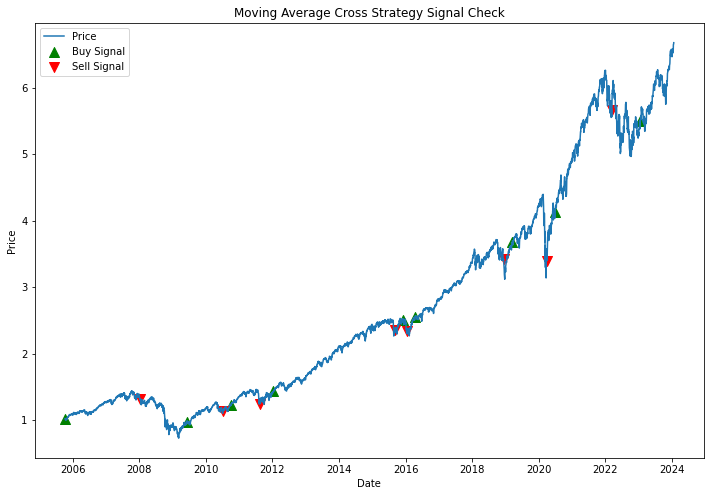

In [5]:

# create moving average cross strategy
strategy_data = spy_etf.total_return_index.to_frame()
strategy_data['master_ticker'] = 'SPY'
ma_cross_strategy = strategy.MovingAverageCrossStrategy(name='Moving Average Cross Strategy 50D vs 200D',
                                                        data=strategy_data, short_window=50, long_window=200,
                                                        price_col_name='total_return_index', start_date='2005-01-03',
                                                        end_date='2024-01-23')
ma_cross_strategy.signal_generation()
ma_cross_strategy.signal_plot('SPY') # plot the signal

## Step 5: Portfolio Simulation

Backtesting Strategy: 100%|███████████████| 4756/4756 [00:17<00:00, 269.03it/s]


Trade output generated for portfolio:  SPX Trend Following


D:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


Performance analysis generated for portfolio:  SPX Trend Following
Backtesting finished for portfolio:  SPX Trend Following
Done!


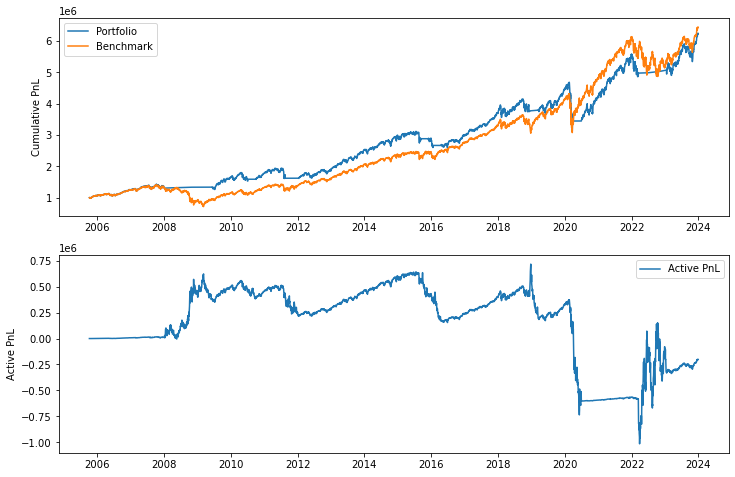

In [6]:

# create portfolio
portfolio_start_date = max(spy_etf.total_return_index.index.min(), cash.cash_rate.index.min(),
                           ma_cross_strategy.signal_history.index.min(),
                           pd.to_datetime('2005-06-30')).strftime('%Y-%m-%d')
portfolio_end_date = min(spy_etf.total_return_index.index.max(), cash.cash_rate.index.max(),
                         pd.to_datetime('2023-12-31')).strftime('%Y-%m-%d')

spy_trend_following_portfolio = portfolio.MultiAssetPortfolio(name='SPX Trend Following', asset_list=[spy_etf, cash],
                                                              start_date=portfolio_start_date,
                                                              end_date=portfolio_end_date,
                                                              initial_capital=1000000, rebalance_freq=None,
                                                              signal_data=ma_cross_strategy.signal_history,
                                                              benchmark=spy_etf.total_return_index.to_frame('SPY'))
spy_trend_following_portfolio.backtesting(is_generate_output=True)
print('Done!')

In [7]:
spy_trend_following_portfolio.portfolio_account.head(5)

,NAV,Income,Available_Cash,Unavailable_Cash
Date,,,,
2005-10-07,999643.69,0,56.3668,0.0
2005-10-10,991202.714566,0.008466,56.375266,0.0
2005-10-11,989782.233871,0.016971,56.383771,0.0
2005-10-12,982009.933577,0.025477,56.392277,0.0
2005-10-13,981424.405975,0.033975,56.400775,0.0


In [8]:
spy_trend_following_portfolio.trade_records.head(10)

,Trade Date,Master_Ticker,Amount,Price,Transaction_Cost,Side,Trade_Rational
0,2005-10-07,SPY,11877.0,84.1616,356.31,Buy,Signal Driven
0,2006-01-31,SPY,89.0,90.1885,2.67,Buy,Dividend Reinvestment
0,2006-04-28,SPY,66.0,93.3669,1.98,Buy,Dividend Reinvestment
0,2006-07-31,SPY,73.0,91.1977,2.19,Buy,Dividend Reinvestment
0,2006-10-31,SPY,71.0,98.7205,2.13,Buy,Dividend Reinvestment
0,2007-01-31,SPY,93.0,103.5641,2.79,Buy,Dividend Reinvestment
0,2007-04-30,SPY,64.0,107.259,1.92,Buy,Dividend Reinvestment
0,2007-07-31,SPY,76.0,105.8541,2.28,Buy,Dividend Reinvestment
0,2007-10-31,SPY,79.0,112.8738,2.37,Buy,Dividend Reinvestment
0,2008-01-04,SPY,12488.0,103.685,374.64,Sell,Signal Driven
